In [31]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install Pillow

Could not fetch URL https://pypi.org/simple/opencv-python/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/opencv-python/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1076)'))) - skipping


ERROR: Could not find a version that satisfies the requirement opencv-python (from versions: none)
ERROR: No matching distribution found for opencv-python


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

##### Resize images that their width and lenfth be a factor of 8

In [2]:
path = 'inputs/P4/'
img_names = ['donald.png', 'joe.png']
for img_name in img_names:
    img = Image.open(path+img_name)    
    new_size = (448, 600)
    resized_img = img.resize(new_size)
    resized_img.save(path + 'dsd_' + img_name, 'png')

#### Part A: Vectorize images

In [3]:
def patch_extract(img_name, gray_scale):
    """ This function  """
    img = Image.open(path+img_name) 
    if gray_scale:
        img = img.convert("L")
        img_vectors = [[]]
    else:
        img_vectors = [[], [], []]
    img_matrix = np.asarray(img)
    for i in range(0, img_matrix.shape[0], 8):
        for j in range(0, img_matrix.shape[1], 8):
            if gray_scale:
                img_block = [img_matrix[i:i+8, j:j+8]]
            else:
                img_block = [img_matrix[i:i+8, j:j+8, 0], img_matrix[i:i+8, j:j+8, 1], img_matrix[i:i+8, j:j+8, 2]]
            for k, block in enumerate(img_block):
                block = np.resize(block, block.shape[0]*block.shape[1])
                img_vectors[k].append(block)
    return [np.array(dim).T for dim in img_vectors]

multi_img_vectors = patch_extract('donald.png', True)

#### Part B: Find eigenvalue and eigenvectors of patches

##### Calculate largest eigen vectors of cov matrix of blocks and plot them

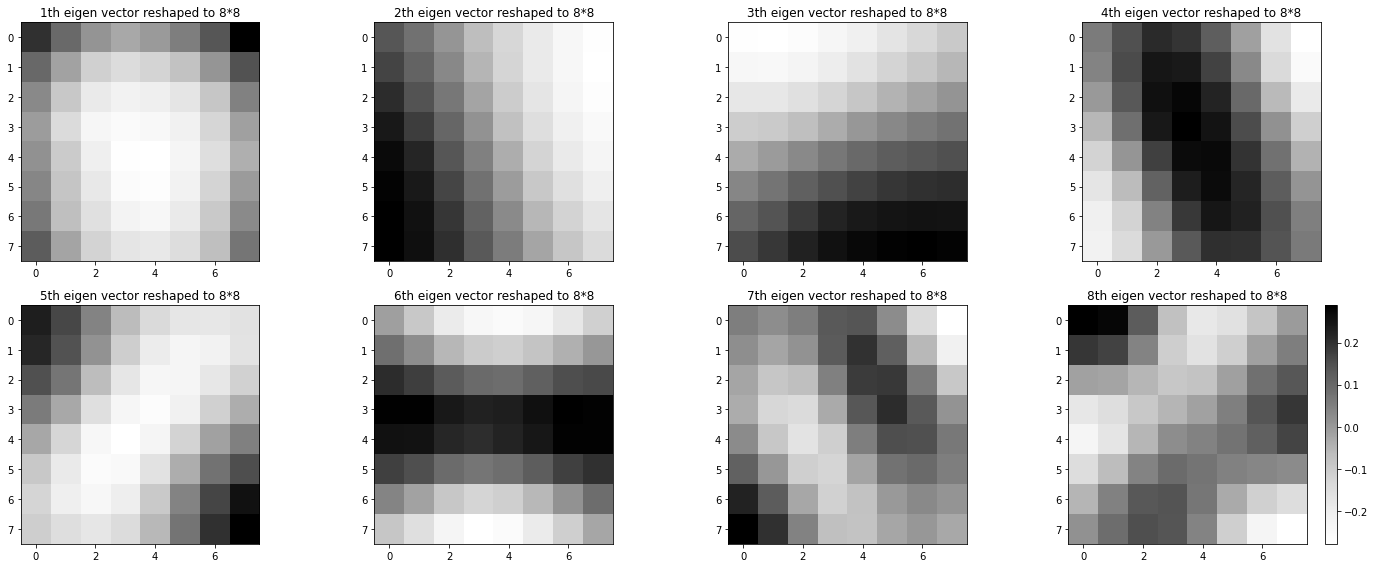

In [4]:
def get_cov_of_patches(matrixes):
    """ This function gets patches of image and returns cov matrix for any dim of image (one for gray scale and 3 for rgb) """
    multi_cov = []
    for matrix in matrixes:
        multi_cov.append(np.cov(matrix)*(matrix.shape[0]-1))
    return multi_cov

def get_k_eig_vectors(matrixes, k):
    """ This function gets all cov matrix and returns k largest eigen vectors of any of them """
    multi_k_eig_vec = []
    for matrix in matrixes:
        eig_val, eig_vec = np.linalg.eig(matrix)
        k_egn_vectors = np.array([eig[1] for eig in sorted(zip(eig_val, eig_vec.T), key=lambda x: x[0], reverse=True)[:k]]).T
        multi_k_eig_vec.append(k_egn_vectors)
    return multi_k_eig_vec

def plot_eig_vectors(multi_eig_vectors):
    """ This function gets eigen vectors and reshape them to 8*8 and then plot them """
    if len(multi_eig_vectors) == 1:
        cmaps = ['Greys']
    else:
        cmaps = ['Reds', 'Greens', 'Blues']
    for j, eig_vectors in enumerate(multi_eig_vectors):
        fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
        for i, vec in enumerate(eig_vectors.T):
            block_eig = vec.reshape((8, 8))
            im = axs[i//4][i%4].imshow(block_eig, cmap=cmaps[j])
            axs[i//4][i%4].title.set_text(str(i+1) + 'th eigen vector reshaped to 8*8')
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

multi_cov = get_cov_of_patches(multi_img_vectors)
multi_eig_vecs = get_k_eig_vectors(multi_cov, 8)
plot_eig_vectors(multi_eig_vecs)

##### Plot mean of blockes

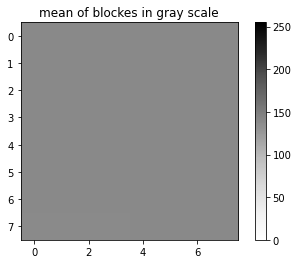

In [5]:
def plot_mean(matrixes):
    """ This function gets patches matrix and plots mean of all blockes """
    if len(matrixes) == 1:
        cmaps = ['Greys']
    else:
        cmaps = ['Reds', 'Greens', 'Blues']
    for i, matrix in enumerate(matrixes):
        mean_block = np.array(matrix.mean(axis=1)).reshape((8, 8))
        im = plt.imshow(mean_block, cmap =cmaps[i], vmin = 0, vmax = 255)
        plt.colorbar(im)
        if len(matrixes) == 1:
            title = 'mean of blockes in gray scale'
        else:
            title = 'mean of blockes of {} in RGB scale'.format({0:'Red', 1:'Green', 2:'Blue'}[i])
        plt.title(title)
        plt.show()
plot_mean(multi_img_vectors)

#### Part C: Compress subimages using eigenvectors

In [6]:
def commpress_subimages(matrixes, k):
    """ This function gets array of matrix and return k largest eigen vectors of (vector-mean) """
    multi_sub_vectors = [np.zeros((matrixes[0].shape[0], matrixes[0].shape[1])) for _ in range(len(matrixes))]
    multi_mean_vector = []
    for i, matrix in enumerate(matrixes):
        mean_vec = matrix.mean(axis=1)
        multi_mean_vector.append(mean_vec)
        for j in range(matrix.shape[0]):  # iterate over rows
            multi_sub_vectors[i][j] = matrix[j] - mean_vec[j]  ## calculate "any_vactors - mean_vector"
    multi_cov = get_cov_of_patches(multi_sub_vectors)
    multi_k_eig_vec = get_k_eig_vectors(multi_cov, k)
    return multi_sub_vectors, multi_mean_vector, multi_k_eig_vec

multi_eig_vectors_per_k = {}
multi_sub_vectors = []
multi_mean_vector = []
for k in [2, 5, 10, 20]:
    compression_info = commpress_subimages(multi_img_vectors, k)
    multi_eig_vectors_per_k[k] = compression_info[2]
    if not multi_sub_vectors or not multi_mean_vector:
        multi_sub_vectors = compression_info[0]
        multi_mean_vector = compression_info[1]

#### Part D: Reconstruct subimages

In [7]:
def reconstruct_subimages(multi_sub_vectors, multi_eig_vectors, multi_mean_vector):
    """ This function reconstrut any blocks of image in loa dimention """
    new_multi_img_vectors = [np.zeros((multi_sub_vectors[0].shape[0], multi_sub_vectors[0].shape[1])) for _ in range(len(multi_sub_vectors))]
#     new_multi_img_vectors = multi_sub_vectors.copy()
    for i, sub_vectors in enumerate(multi_sub_vectors):
        eig_vectors = multi_eig_vectors[i]
        mean_vector = multi_mean_vector[i]
        weights = eig_vectors.T @ sub_vectors  ## weitghts of any eigenvectors for all blocks
        new_sub_vectors = eig_vectors @ weights  ## reconstruct (vectors-mean)
        for j in range(new_sub_vectors.shape[0]):
            new_multi_img_vectors[i][j] = new_sub_vectors[j] + mean_vector[j] 
    return new_multi_img_vectors

new_multi_img_vectors_per_k = {}
for k in [2, 5, 10, 20]:
    new_multi_img_vectors_per_k[k] = reconstruct_subimages(multi_sub_vectors, multi_eig_vectors_per_k[k], multi_mean_vector)

#### Part E: Reconstruct image using recinstructed subimages

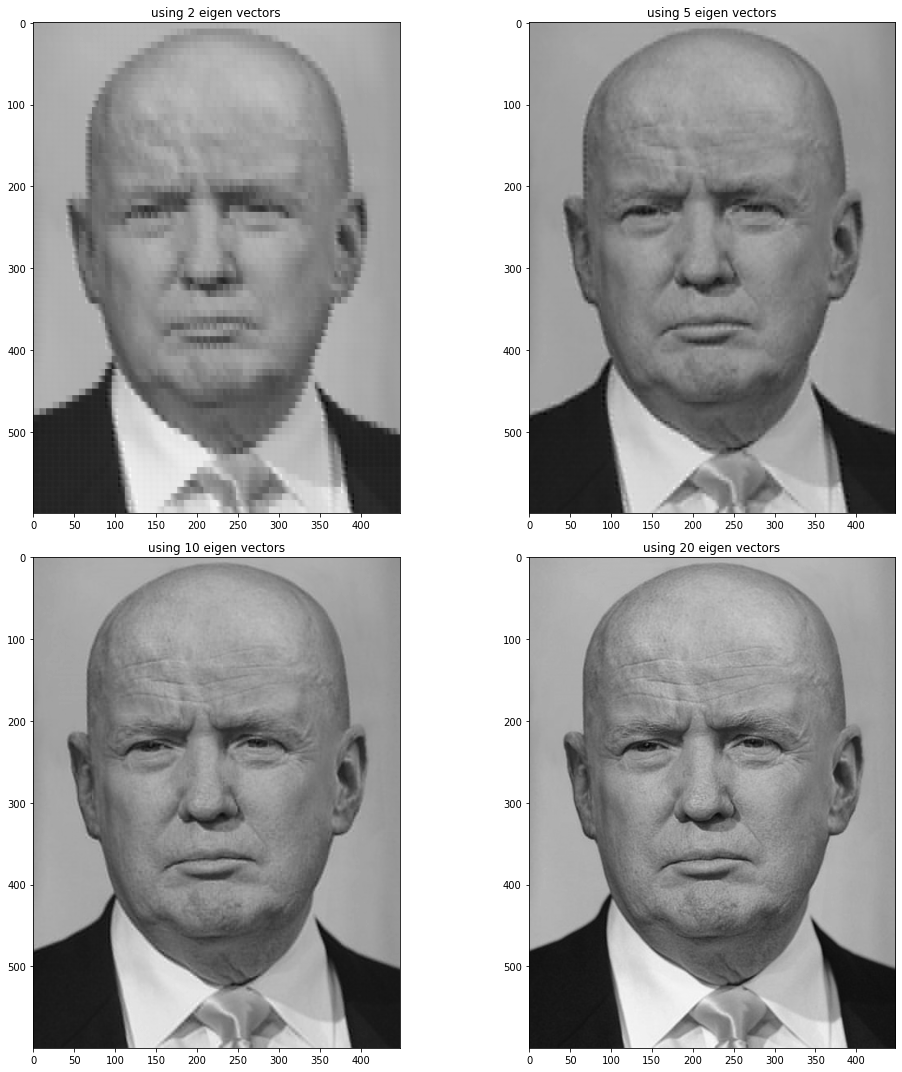

In [8]:
def patch_reconstruct(new_multi_img_vectors):
    """ This function gets new patch vectors and recunstruct image matrix """
    new_img = np.zeros((600, 448, len(new_multi_img_vectors)))
    for i, new_img_vectors in enumerate(new_multi_img_vectors):
        new_matrix = np.zeros((600, 448))
        for j, vec in enumerate(new_img_vectors.T):
            block = vec.reshape((8, 8))
            new_matrix[8*(j//(448//8)):8*(j//(448//8))+8, 8*(j%(448//8)):8*(j%(448//8))+8] = block
        new_img[:,:,i] = new_matrix
    return new_img

def plot_new_img(imgs_per_k):
    """ This function gets image matrixes per k and plot them """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    for i, k in enumerate(imgs_per_k.keys()):
        if imgs_per_k[k].shape[2] == 1:
            axs[i//2][i%2].imshow(imgs_per_k[k], cmap="gray")
        else:
            img = Image.fromarray(imgs_per_k[k].astype('uint8')).convert('RGBA')
            axs[i//2][i%2].imshow(img)
        axs[i//2][i%2].title.set_text('using {} eigen vectors'.format(k))
    plt.tight_layout()
    plt.plot()

new_img_per_k = {}
for k in [2, 5, 10, 20]:
    new_img_per_k[k] = patch_reconstruct(new_multi_img_vectors_per_k[k])
plot_new_img(new_img_per_k)

#### Part F: Repeat all previouse steps for color image

###### convert image matrix to patches

In [9]:
multi_img_vectors_rgb = patch_extract('joe.png', False)

###### Calculate eigen vectors of 8 largest eigen value and plot them

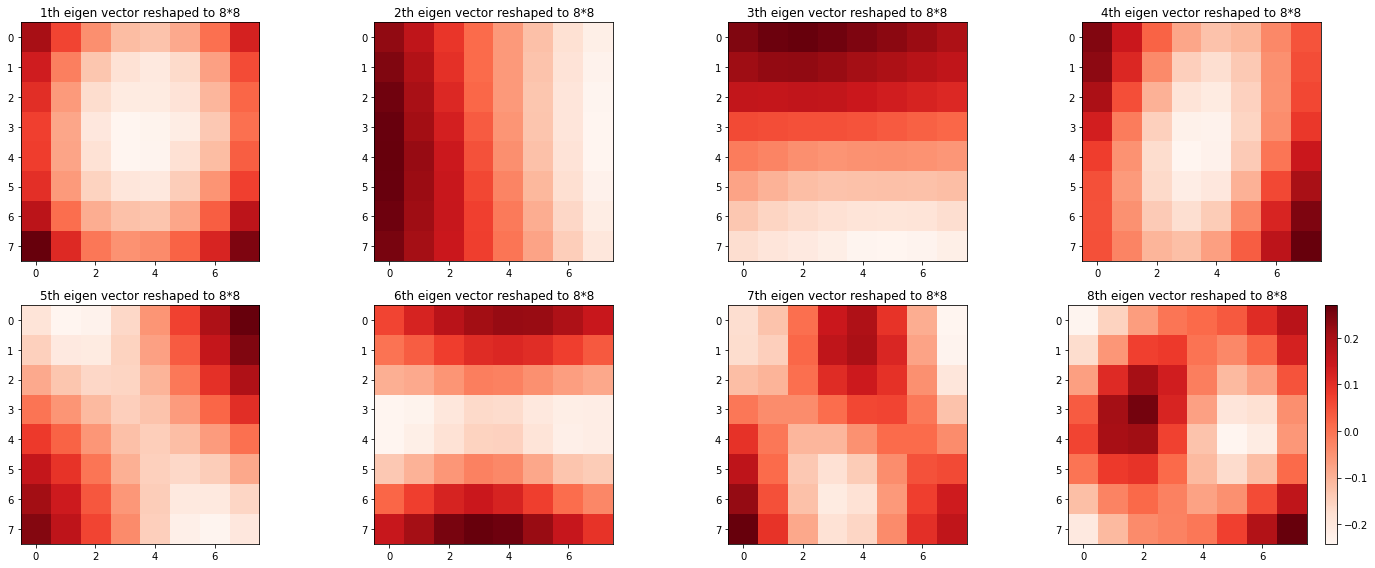

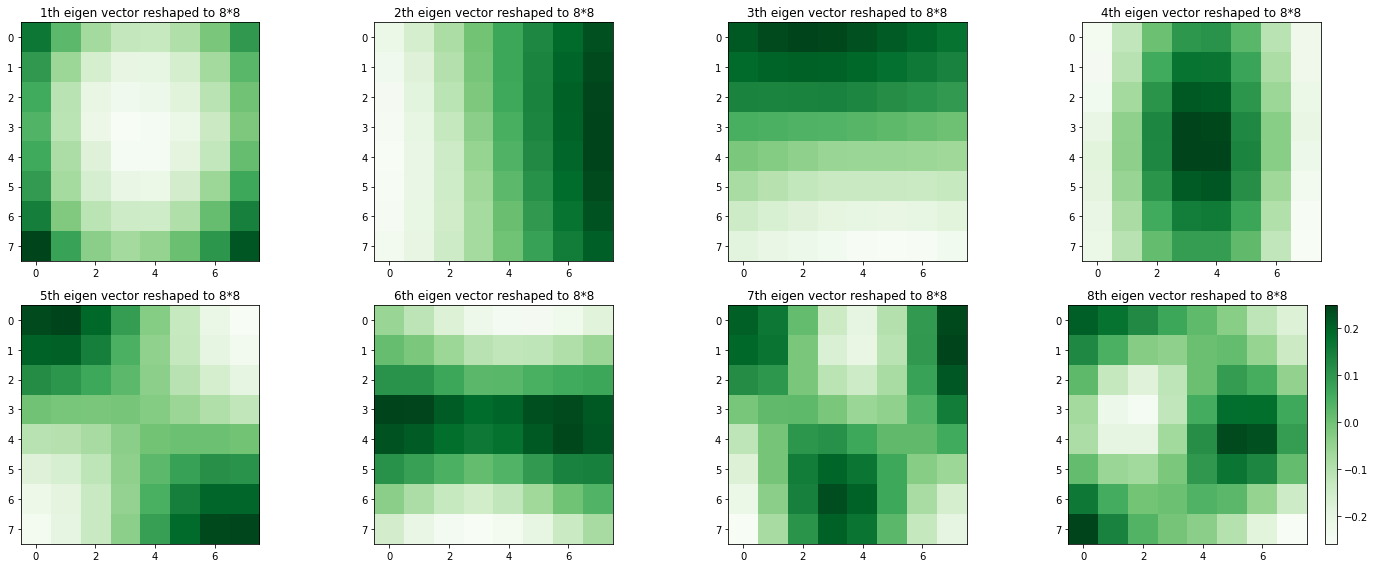

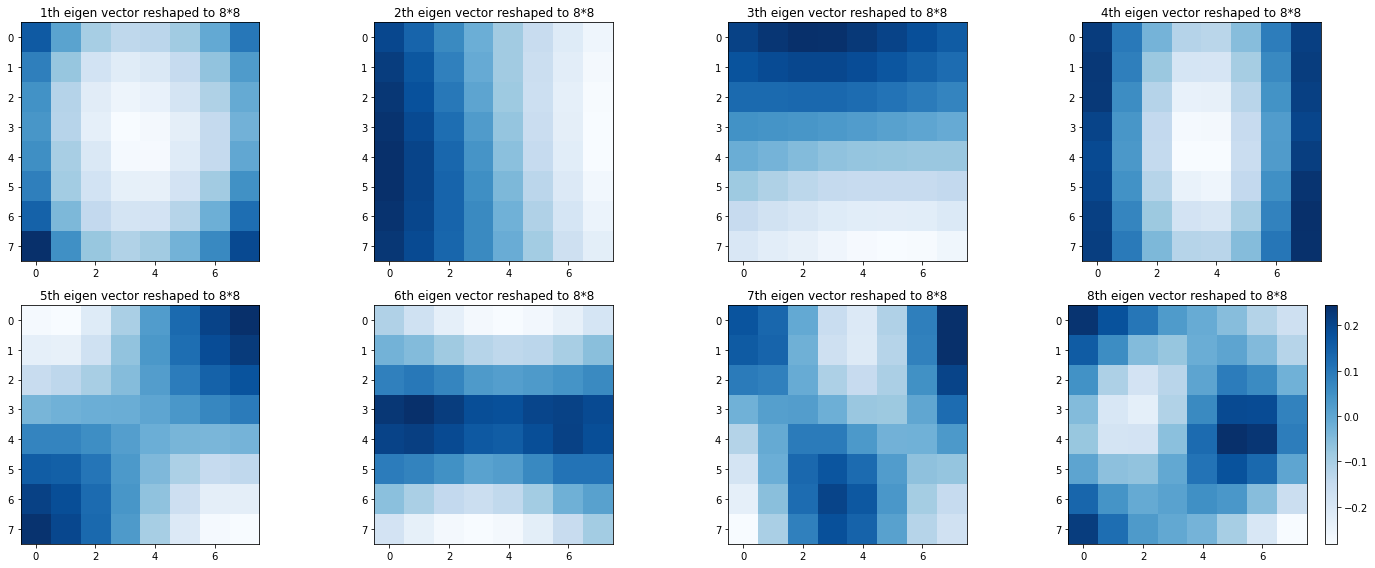

In [10]:
multi_cov_rgb = get_cov_of_patches(multi_img_vectors_rgb)
multi_eig_vecs_rgb = get_k_eig_vectors(multi_cov_rgb, 8)
plot_eig_vectors(multi_eig_vecs_rgb)

###### Plot mean vector of all three dim of vectors (r ,g, b)

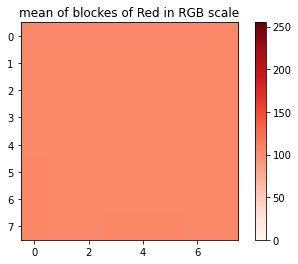

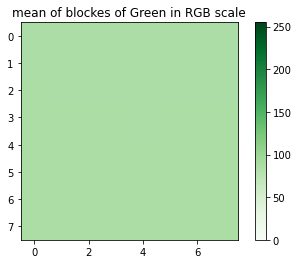

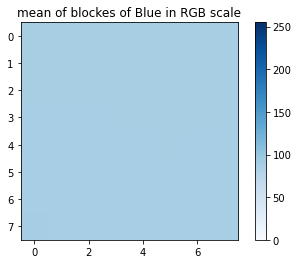

In [11]:
plot_mean(multi_img_vectors_rgb)

###### Calculate k largest eigen vectors and (x-mean)

In [12]:
multi_eig_vectors_rgb_per_k = {}
multi_sub_vectors_rgb = []
multi_mean_vector_rgb = []
for k in [2, 5, 10, 20]:
    compression_info = commpress_subimages(multi_img_vectors_rgb, k)
    multi_eig_vectors_rgb_per_k[k] = compression_info[2]
    if not multi_sub_vectors_rgb or not multi_mean_vector_rgb:
        multi_sub_vectors_rgb = compression_info[0]
        multi_mean_vector_rgb = compression_info[1]

###### Reconstruct patch vectors using selected eigen vectors

In [13]:
new_multi_img_vectors_rgb_per_k = {}
for k in [2, 5, 10, 20]:
    new_multi_img_vectors_rgb_per_k[k] = reconstruct_subimages(multi_sub_vectors_rgb, multi_eig_vectors_rgb_per_k[k], multi_mean_vector_rgb)

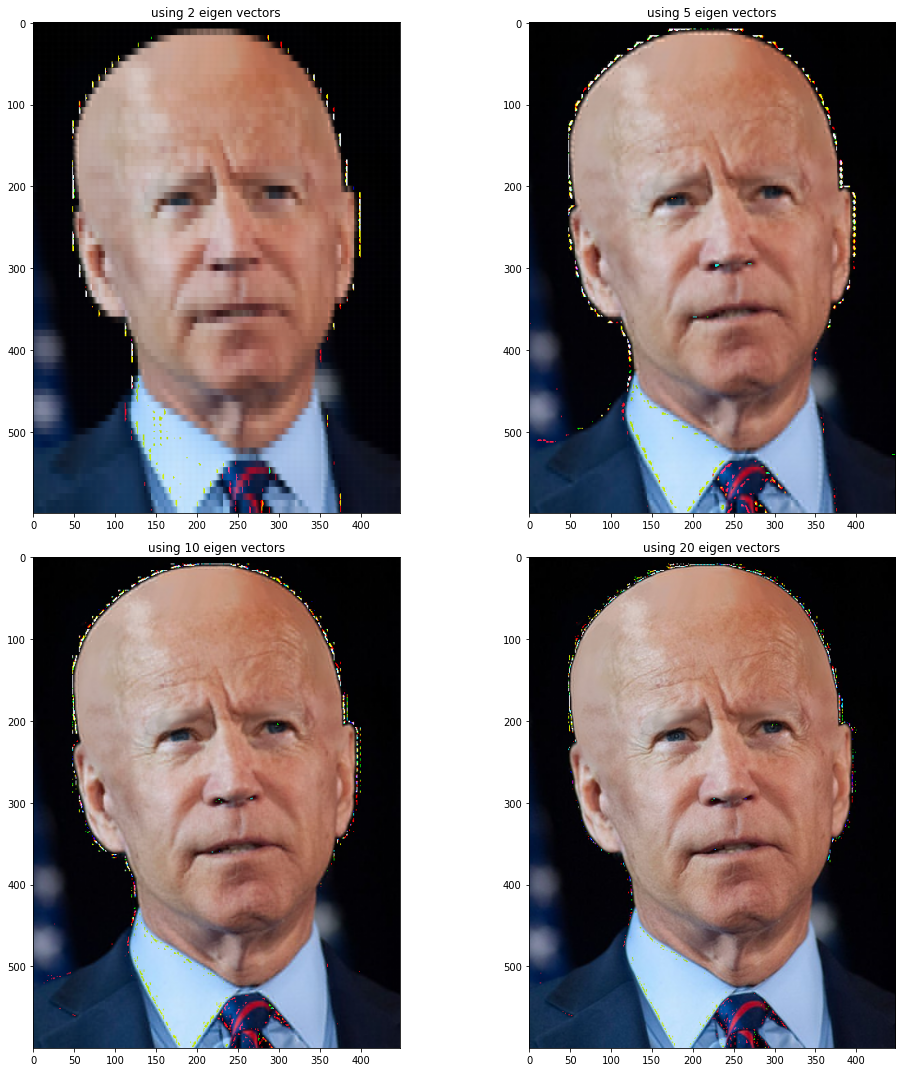

In [14]:
new_img_rgb_per_k = {}
for k in [2, 5, 10, 20]:
    new_img_rgb_per_k[k] = patch_reconstruct(new_multi_img_vectors_rgb_per_k[k])
plot_new_img(new_img_rgb_per_k)